In [ ]:
import epoch as epoch
%reset



In [ ]:
import os
import struct
import numpy as np
def load_mnist(path:str,kind:str="train")->np.array:
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    with open(labels_path,'rb') as lbpath:
        magic,n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path,'rb') as imgpath:
        magic,n,rows,cols=struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape((len(labels),784))
        images = ((images/255.)-.5)
    return images,labels
X_train,y_train = load_mnist('', kind='byte_files/train')
X_train.shape

In [ ]:
X_test,y_test = load_mnist('', kind='byte_files/test')

In [ ]:
X_test

In [ ]:
X_train[y_train==1][0].reshape(28,28)

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)

ax=ax.flatten()
for i in range(10):
    img =X_train[y_train==i][0].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(
    nrows=5,
    ncols=5,
    sharey=True,
    sharex=True
)
ax=ax.flatten()
for i in range(25):
    img =X_train[y_train==7][i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
"""Компресс датасета в архив"""
np.savez_compressed("mnist_scaled.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)


In [ ]:
"""чтение архива npz"""
mnist=np.load("mnist_scaled.npz")
mnist.files

In [ ]:
X_train=mnist['X_train']
X_train

In [ ]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train',
                                    'X_test', 'y_test']]

del mnist

X_train.shape

In [ ]:
import sys
class NeuralNetMlp(object):
    """Нейронная сетья прямого распространения на основе классификатора
    многослойного персептрона
    Параметры
    ----------
    n_hidden : int (по умолчанию: 30)
        количество скрытых элементов

    l2 : float ( по умолчанию 0.)
        значение l2  регуляризации лямбда

    epochs : int (по умолчанию : 100)
        количество подходов к обучающему образцу

    eta : float (по умолчанию 0.001)
        скорость обучения
    shuffle : bool (по умолчанию True)
        тасовка входных данных
    minibatch_size : int( по умолчанию 1)
        Количество обучающих образцов на мини пакет
    seed : int (по умолчанию None)
        Случайные начальные значения для инициализации весов

    Атрибуты
    ---------
    eval_: dict
        словарь, в котором собираются показатели издержек,
        правильности при обучении и правильности при испытании
        для каждой эпохи во время обучения
        """

    def __init__(self, n_hidden=30, l2=0.,epochs=100,
                 eta=0.001, shuffle=True,minibatch_size=1, seed=None):
        self.random=np.random.RandomState(seed)
        self.n_hidden=n_hidden
        self.l2=l2
        self.epochs=epochs
        self.eta=eta
        self.shuffle=shuffle
        self.minibatch_size=minibatch_size

    def _onehot(self,y,n_classes):
        """кодирует метки с унитарным кодом"""

        onehot=np.zeros((n_classes,y.shape[0]))
        for idx,val in enumerate(y.astype(int)):
            onehot[val,idx]=1.
        return onehot.T

    def _sigmoid(self,z):
        return 1./(1.+np.exp(-np.clip(z,-250,250)))

    def _forward(self,X):
        # шаг 1 : общий вход скрытого слоя
        # скалярное произведение {n_examples, n_features}
        # и {n_features, n_hidden}
        # -> {n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        #шаг 2: активация скрытого слоя
        a_h = self._sigmoid(z_h)
        # шаг 3: общий вход выходного слоя
        # скалярное произведение {n_examples, n_hidden}
        # и [n_hidden, п classlabels}
        # -> [n_examples, n_classlabels]
        z_out=np.dot(a_h,self.w_out)+self.b_out
        # шаг 4: активация выходного слоя
        a_out=self._sigmoid(z_out)
        return z_h,a_h,z_out,a_out

    def _compute_cost(self,y_enc,output):
        L2_term = (self.l2 *
                   (np.sum(self.w_h**2.)+np.sum(self.w_out**2.)))
        term1=-y_enc*(np.log(output))
        term2=(1.-y_enc)*np.log(1.-output)
        cost=np.sum(term1-term2)+L2_term
        return cost

    def predict(self,X):
        z_h,a_h,z_out,a_out=self._forward(X)
        y_pred=np.argmax(z_out,axis=1)
        return y_pred

    def fit(self,X_train,y_train,X_valid,y_valid):

        """инициализация"""
        n_output=np.unique(y_train).shape[0]
        n_features=X_train.shape[1]

        self.b_h=np.zeros(self.n_hidden)
        self.w_h=self.random.normal(loc=0.0,scale=0.1,
                                 size=(n_features,self.n_hidden))
        self.b_out=np.zeros(n_output)
        self.w_out=self.random.normal(loc=0.0,scale=0.1,
                                 size=(self.n_hidden,n_output))
        epoch_strlen=len(str(self.epochs))
        self.eval_={'cost':[],'train_acc':[],'valid_acc':[]}
        y_train_enc=self._onehot(y_train,n_output)

        for i in range(self.epochs):
            indices=np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0]- self.minibatch_size+
                                   1,self.minibatch_size):

                batch_idx=indices[start_idx:start_idx+self.minibatch_size]

                """прямое распространение"""
                z_h,a_h,z_out,a_out=self._forward(X_train[batch_idx])

                """обратное  распространение"""
                delta_out=a_out-y_train_enc[batch_idx]

                sigmoid_derivative_h=a_h*(1.-a_h)

                delta_h=(np.dot(delta_out,self.w_out.T)*sigmoid_derivative_h)

                grad_w_h=np.dot(X_train[batch_idx].T,delta_h)
                grad_b_h=np.sum(delta_h,axis=0)

                grad_w_out=np.dot(a_h.T,delta_out)
                grad_b_out=np.sum(delta_out,axis=0)

                delta_w_h=(grad_w_h + self.l2*self.w_h)
                delta_b_h=grad_b_h
                self.w_h-=self.eta*delta_w_h
                self.b_h-=self.eta*delta_b_h

                delta_w_out=(grad_w_out+self.l2*self.w_out)
                delta_b_out=grad_b_out
                self.w_out-=self.eta*delta_w_out
                self.b_out-=self.eta*delta_b_out

            """оценка"""
            z_h,a_h,z_out,a_out=self._forward(X_train)
            cost=self._compute_cost(y_enc=y_train_enc,output=a_out)
            y_train_pred=self.predict(X_train)
            y_valid_pred=self.predict(X_valid)
            train_acc=((np.sum(y_train==y_train_pred)).astype(np.float) /
                       X_train.shape[0])

            valid_acc=((np.sum(y_valid==y_valid_pred)).astype(np.float) /
                       X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                         '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                         (epoch_strlen, i+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

nn=NeuralNetMlp(n_hidden=100,l2=0.01,epochs=150,eta=0.0005,minibatch_size=100,shuffle=True,seed=1)

In [ ]:
nn.fit(
    X_train=X_train[:55000],
    y_train=y_train[:55000],
    X_valid=X_train[55000:],
    y_valid=y_train[55000:]
)


In [ ]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

In [ ]:
plt.plot(range(nn.epochs),nn.eval_['train_acc'], label='обучение')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'], label='проверка',
         linestyle='--')
plt.ylabel('Правильность')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()



In [ ]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test==y_test_pred).astype(np.float)/X_test.shape[0])
print('Правильность при испытании : %.2f%%' %(acc*100))

In [ ]:
misci_img =X_test[y_test!=y_test_pred][:25]
correct_lab=y_test[[y_test!=y_test_pred]][:25]
misci_lab=y_test_pred[y_test!=y_test_pred][:25]
fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(25):
    img=misci_img[i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys',interpolation='nearest')
    ax[i].set_title(f'{i+1}) t:{correct_lab[i]} p:{misci_lab[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=3)
a=np.array([1,2,3,4,5], dtype=np.int32)
b=[6,7,8]
t_a=tf.convert_to_tensor(a)
t_b=tf.convert_to_tensor(b)
print(t_a,t_b)

In [ ]:
t_ones=tf.ones((2,3))
t_ones.shape


In [ ]:
t_ones.numpy()
#509

In [ ]:
t_a_new=tf.cast(t_a,tf.int64) #меняем тип тензора
t_a_new.dtype

In [ ]:
t = tf.random.uniform(shape=(3,5))
t

In [ ]:
tf.transpose(t)

In [ ]:
# tf.reshape(t,shape=(5,6))

In [ ]:
t=tf.zeros((1,2,1,4,1))
tf.squeeze(t,axis=(2,4)) #меняем ращмерность тензора


In [ ]:
tf.random.set_seed(1)
t1=tf.random.uniform(shape=(5,2), minval=-1.,maxval=1.)
t2=tf.random.normal(shape=(5,2),mean=.0,stddev=1.)
t1

In [ ]:
t2

In [ ]:
tf.multiply(t1,t2) # умножение тензоров


In [ ]:
tf.math.reduce_sum(t2) #сумма

In [ ]:
mn1=tf.math.reduce_mean(t1,axis=1)
std1=tf.math.reduce_std(t1,axis=1)
print(t1.numpy())
print(mn1)
print(std1)

In [ ]:
print(t1)
print(t2)
print(tf.matmul(t1,t2,transpose_b=True)) #матричное умножение

In [ ]:
print(tf.norm(t1,ord=2,axis=1).numpy()) #расчитываем норму L2
print(np.sqrt(np.sum(np.square(t1),axis=1)))

In [ ]:
t=tf.random.uniform((6,))
t.numpy()

In [ ]:
t_splits=tf.split(t,num_or_size_splits=3)#делим тензор на три части
[item.numpy() for item in t_splits]

In [ ]:
t=tf.random.uniform((5,))
t_splits=tf.split(t,num_or_size_splits=(3,2))
print(t.numpy())
print([item.numpy() for item in t_splits])


In [ ]:
A=tf.ones((3,))

B=tf.zeros((3,))
C=tf.concat([A,B],axis=0)#соединение тензоров
print(A.numpy())
print(B.numpy())
print(C.numpy())

In [ ]:
A=tf.ones((3,))
B=tf.zeros((3,))
tf.stack([A,B],axis=1)#соединение стопкой (как zip)

In [ ]:
"""создание наборов данных из имеющихся структур"""
a=[1.2,3,4,5,5,1,0]
ds=tf.data.Dataset.from_tensor_slices(a)
print(ds)

In [ ]:
for item in ds:
    print(item)


In [ ]:
"""создаем пакеты из имеющегося датасета"""
ds_batch=ds.batch(3)#внутри указывается размер каждого пакета
for i,elem in enumerate(ds_batch,1):
    print(f"пакет:{i,elem.numpy()}")

In [ ]:
t_x = tf.random.uniform([4,3], dtype=tf.float32)
t_y = tf.range(4)
print(t_x)
print(t_y)
ds_x=tf.data.Dataset.from_tensor_slices(t_x)
ds_y=tf.data.Dataset.from_tensor_slices(t_y)
ds_joint=tf.data.Dataset.zip((ds_x,ds_y))
for example in ds_joint:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

In [ ]:
ds_trans=ds_joint.map(lambda x,y : (x*2-1.,y))

for example in ds_trans:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

In [ ]:
ds=ds_joint.shuffle(buffer_size=len(t_x))#тасует элементы,buffer_size - количество элементов в набое
for example in ds:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')


In [ ]:
ds=ds_joint.batch(batch_size=3,drop_remainder=False)
batch_x,batch_y=next(iter(ds))
print(f'Пакет x{batch_x.numpy()}')
print(f'Пакет y{batch_y.numpy()}')


In [ ]:
"""Повтор"""
ds=ds_joint.batch(3).repeat(count=2)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())


In [ ]:
"""Повтор """
ds=ds_joint.repeat(count=2).batch(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())



In [ ]:
"""тасование создание пакетов повторение"""
ds=ds_joint.shuffle(4).batch(2).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())

In [ ]:
"""создание пакетов тасование  повторение"""
ds=ds_joint.batch(2).shuffle(4).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())
#520

In [ ]:
import pathlib
imdir_path=pathlib.Path('cat_fish')
file_list=sorted([str(path) for path in imdir_path.glob('*.jpg') ])
file_list

In [ ]:
img_height,img_width=120,80
img_raw=tf.io.read_file(file_list[0])
img=tf.image.decode_jpeg(img_raw)
img.numpy()

In [ ]:
img=tf.image.resize(img,[img_height,img_width])
img

In [ ]:
img/=255.
img

In [ ]:
img.shape

In [ ]:
fig=plt.figure(figsize=(10,5))
for i,file in enumerate(file_list):
    img_raw=tf.io.read_file(file)
    img=tf.image.decode_jpeg(img_raw)
    print(f'Размер изображения {file, img.shape}')
    ax=fig.add_subplot(2,3,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file),size=15)
plt.tight_layout()
plt.show()


In [ ]:
labels=[1 if 'fish' in os.path.basename(file) else 0 for file in file_list]
labels

In [ ]:
"""создаем датасет тензоров совмещенный с метками"""
ds_files_labels=tf.data.Dataset.from_tensor_slices((file_list,labels))
for item in ds_files_labels:
    print(item[0].numpy(),item[1].numpy())

In [ ]:
list(ds_files_labels)

In [ ]:
img_height,img_width=120,80
def load_and_process(path:str,label:list):
    """Открывает, обрабатывает, и приводит к одному размеру изображение,
    после нормализует /255"""
    image=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,[img_height,img_width])
    image/=255.
    return image,label
ds_images_labels=ds_files_labels.map(load_and_process) #применяет функцию load_and_process к каждой паре изображения и метки датасета
fig=plt.figure(figsize=(10,6))
for i,example in enumerate(ds_images_labels):
    ax=fig.add_subplot(2,3,i+1)
    # print(example,type(example))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title(f'{example[1].numpy()}',size=15)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow_datasets as tfds
tfds.list_builders()


In [ ]:
"""Метод извлечения набора данных на примере mnist
1.Вызов функции построителя набора данных
2.выполнение метода download_and_prepare()
3.Вызов метода as_dataset()"""

mnist_bldr=tfds.builder('mnist')
mnist_bldr.info.features

In [ ]:
mnist_bldr.info.citation

In [ ]:
mnist,mnist_info=tfds.load('mnist',with_info=True,
                           shuffle_files=False)
mnist_info

In [ ]:
mnist.keys()

In [ ]:
ds_train=mnist['train']
ds_train=ds_train.map(lambda item: (item['image'],item['label']))
ds_train=ds_train.batch(10) #создаем 10 пакетов
batch=next(iter(ds_train))
print(batch[0].shape,batch[1])
fig = plt.figure(figsize=(15,6))
for i,(image,label) in enumerate(zip(batch[0],batch[1])):
    ax=fig.add_subplot(2,5,i+1) #2 ряда 5 колонок
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(image[:,:,0],cmap='gray_r')
    ax.set_title(f'{label}',size=15)
plt.show()


In [ ]:
X_train=np.arange(10).reshape((10,1))
y_train=np.array([1.,1.3,3.1,2.,5.,6.3,6.6,7.4,8.,9.])
plt.plot(X_train,y_train,'o',markersize=10)
plt.show()

In [ ]:
X_train_norm=(X_train-np.mean(X_train))/np.std(X_train)
ds_train_orig=tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm,tf.float32),
     tf.cast(y_train,tf.float32)))
ds_train_orig


In [ ]:
from tensorflow.keras import Model
"""Генерируем ленейную регрессию wx+b"""
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.w=tf.Variable(0.0,name='weight')
        self.b=tf.Variable(0.0,name='bias')
    def call(self, x):
        return self.w*x+self.b

model=MyModel()
model.build(input_shape=(None,1)) # None - заполнитель первого измерения входного тензора, что позволяет использовать произвольный размер пакета. Количество признаков - 1
model.summary()

In [ ]:
def loss_fn(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as tape :
        current_loss=loss_fn(model(inputs),outputs)
    dW,db=tape.gradient(current_loss,[model.w,model.b])
    model.w.assign_sub(learning_rate*dW)
    model.b.assign_sub(learning_rate*db)
tf.random.set_seed(1)
num_epochs=200
log_steps=100
learning_rate=0.001
batch_size=1
steps_per_epoch=int(np.ceil(len(y_train)/batch_size))
ds_train=ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train=ds_train.repeat(count=None) #if none infinit repeats
ds_train=ds_train.batch(1)
Ws,bs=[],[]
for i,batch in enumerate(ds_train):
    if i>=steps_per_epoch*num_epochs:
        #прекратить бесконечный цикл повторений
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    bx,by=batch
    loss_val=loss_fn(model(bx),by)

    train(model,bx,by,learning_rate=learning_rate)
    if i%log_steps==0:
        print(f'Эпоха: {int(i/steps_per_epoch)},Шаг: {i},Потеря: {loss_val}')

In [ ]:
X_test=np.linspace(0,9,num=100).reshape(-1,1)
X_test_norm=(X_test-np.mean(X_train))/np.std(X_train)
y_pred=model(tf.cast(X_test,tf.float32))
fig=plt.figure(figsize=(13,5))
ax=fig.add_subplot(1,2,1)
plt.plot(X_train_norm,y_train,'o',markersize=10)
plt.plot(X_test_norm,y_pred,'--',lw=3)
plt.legend(['Обучающие образцы','Линейная регрессия'])
ax.set_xlabel('x',size=15)
ax.set_ylabel('y',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
plt.plot(Ws,lw=3)
plt.plot(bs,lw=3)
plt.legend(['W','смещ.'],fontsize=15)
ax.set_xlabel('Итерация',size=15)
ax.set_ylabel('Значение',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [ ]:
tf.random.set_seed(1)
model=MyModel()
model.compile(optimizer='sgd',loss=loss_fn,metrics=['mae','mse'])
model.fit(X_train_norm,y_train,epochs=num_epochs,batch_size=batch_size,
          verbose=1)

In [ ]:
iris,iris_info=tfds.load('iris',with_info=True)
print(iris_info)


In [ ]:
"""Расщепление данных на тренировочные и тестовые наборы с тасовкой"""
tf.random.set_seed(1)
ds_orig=iris['train']
ds_orig=ds_orig.shuffle(150,reshuffle_each_iteration=False)
ds_train_orig=ds_orig.take(100)
ds_test=ds_orig.skip(100)
print(ds_train_orig)
print(ds_test)

In [ ]:
for i in ds_train_orig:
    print(i.keys())
    print(i['features'].numpy(),i['features'].numpy().shape)
    print(i['label'].numpy())
    break

In [ ]:
"""трансформируем словарь в кортеж"""
ds_train_orig=ds_train_orig.map(lambda x: (x['features'],x['label']))
ds_test=ds_test.map(lambda x: (x['features'],x['label']))
ds_train_orig

In [ ]:
for i in ds_train_orig:
    print(i[0].numpy(),i[1].numpy())
    break

In [ ]:
"""Dense - полносвязный слой(линейный) лучше всего может быть представлен в виде
f(w*x+b), x - входные признаки, w и b - матрицы весов и смещений"""
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
iris_model=Sequential()
iris_model.add(Dense(16,activation='sigmoid',name='fc1',
               input_shape=(4,)))#Принимаем на вход данные из 4 признаков(смотри размерность массива features) и передаем их на расчет 16 нейронам по функции сигмоида
iris_model.add(Dense(3,name='fc2',activation='softmax'))#принимает на вход выход предыдущего слоя(16) и проецирует на 3 нейрона(так как три метки классов - смотри label массива)
iris_model.summary()
"""формула расчета параметров (n_in+1)*n_out,
при этом матрица весов w размера n_in*n_out,и матрица
смещения b размера n_out"""


In [ ]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
num_epochs=100
training_size=100
batch_size=2
steps_per_epoch=np.ceil(training_size/batch_size)
ds_train=ds_train_orig.shuffle(buffer_size=training_size)
ds_train=ds_train.repeat()
ds_train=ds_train.batch(batch_size=batch_size)
ds_train=ds_train.prefetch(buffer_size=1000)
ds_train

In [ ]:
history=iris_model.fit(ds_train,epochs=num_epochs,steps_per_epoch=steps_per_epoch,
                       verbose=0)

In [ ]:
hist=history.history
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.set_title('Потеря при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.set_title('Точность при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [ ]:
print("Текущий размер",len(list(ds_test.as_numpy_iterator())))
for i in ds_test.batch(50):
    print(i[0].numpy(),i[0].numpy().shape)
    print(i[1].numpy())

In [ ]:
results=iris_model.evaluate(ds_test.batch(1),verbose=0) #batch увеличивает ранг тензоров на 1, в данном случае 1 пакет размером 50
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')

In [ ]:
"""сохранение и загрузка обученной модели"""
iris_model.save('iris_classifier.h5',overwrite=True,
                include_optimizer=True,save_format='h5')


In [ ]:
loaded_model=tf.keras.models.load_model('iris_classifier.h5')
loaded_model.summary()

In [ ]:
results=loaded_model.evaluate(ds_test.batch(1),verbose=1)
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')


In [ ]:
tf.expand_dims

In [ ]:
model=Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
model.build(input_shape=(None,4))
model.summary()

In [ ]:
for i in model.variables:
    print(f'{i.name}, {i.trainable}, {i.shape}')


In [ ]:
"""Для двоичной классификации"""
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.Accuracy(),
                       tf.metrics.Precision(),
                       tf.metrics.Recall()])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)
x=np.random.uniform(low=-1,high=1,size=(200,2))
y=np.ones(len(x))
y[x[:,0]*x[:,1]<0]=0
x_train=x[:100,:]
y_train=y[:100]
x_valid=x[100:,:]
y_valid=y[100:]
fig=plt.figure(figsize=(6,6))
plt.plot(x[y==0,0],x[y==0,1],'o',alpha=0.75,markersize=10)
plt.plot(x[y==1,0],x[y==1,1],'<',alpha=0.75,markersize=10)
plt.xlabel('x_1',size=15)
plt.ylabel('x_2',size=15)
plt.show()

In [ ]:
x.shape

In [ ]:
"""Лог регрессия"""
model=Sequential()
model.add(Dense(1,input_shape=(2,),activation='sigmoid'))
model.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)


In [ ]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
"""Моё решение"""
model=Sequential()
model.add(Dense(4,input_shape=(2,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)

In [ ]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
"""пример создания сложных моделей по апи керас"""
#input layer
inputs=tf.keras.Input(shape=(2,))

#hidden layers
h1=Dense(4,input_shape=(2,),activation='relu')(inputs)
h2=Dense(8,activation='relu')(h1)
h3=Dense(8,activation='relu')(h2)
h4=Dense(4,activation='relu')(h3)

#outputs
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(h4)

#constructing
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)


In [ ]:
"""аналог создания той же модели, но через класс"""
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.hidden1=Dense(4,input_shape=(2,),activation='relu')
        self.hidden2=Dense(8,activation='relu')
        self.hidden3=Dense(8,activation='relu')
        self.hidden4=Dense(4,activation='relu')
        self.output_layer=Dense(1,activation='sigmoid')
    def call(self,inputs):
        h=self.hidden1(inputs)
        h=self.hidden2(h)
        h=self.hidden3(h)
        h=self.hidden4(h)

        return self.output_layer(h)
model=MyModel()
model.build(input_shape=(None,2))
model.summary()

In [ ]:
"""Создадим свой кастомный слой w(x+e)+b,
где е - случайный шум"""
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self,output_dim,noise_stddev=0.1,**kwargs):
        self.output_dim=output_dim
        self.noise_stddev=noise_stddev
        super(NoisyLayer,self).__init__(**kwargs)
    def build(self,input_shape):
        self.w=self.add_weight(name='weights',shape=(input_shape[1],self.output_dim),
                               initializer='random_normal',trainable=True)
        self.b=self.add_weight(shape=(self.output_dim,),initializer='zeros',
                               trainable=True)
    def call(self,inputs,training=False):
        if training:
            batch=tf.shape(inputs)[0]
            dim=tf.shape(inputs)[1]
            noise=tf.random.normal(shape=(batch,dim),mean=0.0,stddev=self.noise_stddev) #добавляем случайный шум е
            noisy_inputs=tf.add(inputs,noise)
        else:
            noisy_inputs=inputs
        z=tf.matmul(noisy_inputs,self.w)+self.b
        return tf.keras.activations.relu(z)
    def get_config(self):
        config=super(NoisyLayer,self).get_config()
        config.update({'output_dim':self.output_dim,
                       'noise_stddev':self.noise_stddev})
        return config
# tf.random.set_seed(1)
# n_l=NoisyLayer(4)
# n_l.build(input_shape=(None,4))
# x=tf.zeros(shape=(1,4))
# tf.print(n_l(x,training=True))

In [ ]:
#значания отличиаются из за входного шума
# config=n_l.get_config()
# new_layer=NoisyLayer.from_config(config)
# tf.print(new_layer(x,training=True))

In [ ]:
model=Sequential()
model.add(NoisyLayer(4,noise_stddev=0.1))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None,2))
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)



In [ ]:
history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
import pandas as pd
dataset_path=tf.keras.utils.get_file(
    "auto-mpg.data",("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
)
column_name=['MPG','Cylinders','Displacement','Horsepower',
             'Weight','Acceleration','ModelYear','Origin']
df=pd.read_csv(dataset_path,names=column_name,
               na_values='?',comment='\t',
               sep=' ',skipinitialspace=True)
df.dropna()
df=df.reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,train_size=0.8)
train_stats=df_train.describe().transpose()
numeric_column_names=['Cylinders','Displacement','Horsepower',
             'Weight','Acceleration']
df_train_norm,df_test_norm=df_train.copy(),df_test.copy()
for col_name in numeric_column_names:
    mean=train_stats.loc[col_name,'mean']
    std=train_stats.loc[col_name,'std']
    df_train_norm.loc[:,col_name]=(df_train_norm.loc[:,col_name]-mean)/std
    df_test_norm.loc[:,col_name]=(df_test_norm.loc[:,col_name]-mean)/std
df_train_norm.tail()

In [ ]:
df.describe()

In [ ]:
"""столбцы флоат будут образовывать непрерывные признаки,
feature_column преобразует непрерывные признаки  в структуру
данных столбец признаков"""
numeric_features=[]
for col_name in numeric_column_names:
    numeric_features.append(
        tf.feature_column.numeric_column(key=col_name)
    )
numeric_features

In [ ]:
df.columns

In [ ]:
df

In [ ]:
feature_years=tf.feature_column.numeric_column(key='ModelYear')
bucketized_features=[]
bucketized_features.append(
    tf.feature_column.bucketized_column(
        source_column=feature_years,
        boundaries=[73,76,79]
    )
)
feature_origin=tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1,2,3]
)
categorical_indicator_features=[]
categorical_indicator_features.append(
    tf.feature_column.indicator_column(feature_origin)
)

In [ ]:
df_train_norm

In [ ]:
"""Шаг 1 определение функции загрузки данных"""
def train_input_fn(df_train,batch_size=8):
    df_train=df_train.dropna()
    df=df_train.copy()
    train_x,train_y=df,df.pop("MPG")
    dataset=tf.data.Dataset.from_tensor_slices(
        (dict(train_x),train_y)
    )
    #тасование, повторение и разбиение на пакеты
    return dataset.shuffle(1000).repeat().batch(batch_size)

#смотрим что получилось
ds = train_input_fn(df_train_norm)
batch=next(iter(ds))
print(batch[0]['ModelYear'])

In [ ]:
def eval_input_fn(df_test,batch_size=8):
    df_test=df_test.dropna()
    df=df_test.copy()
    test_x,test_y=df,df.pop("MPG")
    dataset=tf.data.Dataset.from_tensor_slices(
        (dict(test_x),test_y)
    )
    #тасование, повторение и разбиение на пакеты
    return dataset.shuffle(1000).repeat().batch(batch_size)
all_feature_columns=(numeric_features+bucketized_features+categorical_indicator_features)
all_feature_columns

In [ ]:
def demo(feature_column,data=df_train_norm):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(dict(data)).numpy())
demo(bucketized_features)

In [ ]:
"""шаг 2 сделан, когда преобразовывали признаки"""
# demo(categorical_indicator_features)

In [ ]:
# tf.keras.estimator.DNNRegressor()
"""Шаг 3 - создаем оценщика"""
regressor=tf.estimator.DNNRegressor(
    hidden_units=[32,10],
    feature_columns=all_feature_columns,
    model_dir='models/autompg-dnnregressor/'
)
EPOCHS=1000
BATCH_SIZE=8
total_steps=EPOCHS*int(np.ceil(len(df_train)/BATCH_SIZE))
print(f"Шаги обучения {total_steps}")


In [ ]:
regressor.train(
    input_fn=lambda :train_input_fn(
        df_train_norm,batch_size=BATCH_SIZE
    ),steps=total_steps
)

In [ ]:
reloaded_regressor=tf.estimator.DNNRegressor(
    hidden_units=[32,10],
    feature_columns=all_feature_columns,
    model_dir='models/autompg-dnnregressor/',
    warm_start_from='models/autompg-dnnregressor/'
)

In [ ]:
# eval_results=regressor.evaluate(
#     input_fn=lambda :eval_input_fn(
#         df_test_norm,batch_size=8
#     )
# )
# print(f"Средняя потеря: {eval_results['average_loss']}")

In [ ]:
pred_res=regressor.predict(
    input_fn=lambda :eval_input_fn(
        df_test_norm,batch_size=BATCH_SIZE
    )
)
print(next(iter(pred_res)))


In [ ]:
"""новый оценщик"""
boosted_tree=tf.estimator.BoostedTreesRegressor(
    n_batches_per_layer=20,n_trees=200,
    feature_columns=all_feature_columns
)
boosted_tree.train(input_fn=lambda :train_input_fn(
        df_train_norm,batch_size=BATCH_SIZE
    ),steps=total_steps)

In [ ]:
eval_results=boosted_tree.evaluate(input_fn=lambda :eval_input_fn(
        df_test_norm,batch_size=BATCH_SIZE
    ),steps=total_steps)
print(f"Средняя потеря {eval_results['average_loss']}")

In [ ]:
%reset

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
"""Пример с MNIST"""
BUFFER_SIZE=10000
BATCH_SIZE=64
NUM_EPOCHS=20
steps_per_epoch=np.ceil(60000/BATCH_SIZE)


In [ ]:
"""Шаг 1 определение входных функций"""
def preprocess(item):
    img=item['image']
    label=item['label']
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=tf.reshape(img,(-1,))
    return {'image-pixels':img},label[...,tf.newaxis]

def train_input_fn():
    dataset=tfds.load(name='mnist')
    print(f'Train dataset {dataset}')
    mnist_train=dataset['train']
    dataset=mnist_train.map(preprocess)
    dataset=dataset.shuffle(BUFFER_SIZE)
    dataset=dataset.batch(BATCH_SIZE)
    print(f'Train maped {dataset}')
    return dataset.repeat()

def test_input_fn():
    dataset=tfds.load(name='mnist')
    print(f'Test dataset {dataset}')
    mnist_train=dataset['test']
    dataset=mnist_train.map(preprocess).batch(BATCH_SIZE)
    print(f'Test maped {dataset}')
    return dataset
test_input_fn()

In [ ]:
dataset=tfds.load(name='mnist')
print(f'Train dataset {dataset}')
mnist_train=dataset['train']
dataset=mnist_train.map(preprocess)
dataset= dataset.repeat()
# next(iter(dataset))[0]['image-pixels'].numpy()
# for i in dataset:
#     # print(i.numpy())
#     print(i[0]['image-pixels'].numpy())
#     break

In [ ]:
"""Шаг2 создание признаков"""
image_feature_column=tf.feature_column.numeric_column(
    key='image-pixels', shape=(28*28)
)
image_feature_column

In [ ]:
"""Шаг3 создание модели оценщика"""
dnn_class=tf.estimator.DNNClassifier(
    feature_columns=[image_feature_column],
    hidden_units=[32,16],
    n_classes=10
)

In [ ]:
"""Шаг4 обучение"""
dnn_class.train(
    input_fn=train_input_fn,
    steps=NUM_EPOCHS*steps_per_epoch
)

In [ ]:
eval_results=dnn_class.evaluate(input_fn=test_input_fn)
eval_results




In [ ]:
"""Создание специального оценщика"""
tf.random.set_seed(1)
np.random.seed(1)

x=np.random.uniform(low=-1,high=1,size=(200,2))
y=np.ones(len(x))
print(x)
print(y)

In [ ]:
y[x[:,0]*x[:,1]<0]=0
y

In [ ]:
x_train=x[:100,:]
y_train=y[:100]
x_valid=x[100:,:]
y_valid=y[100:]

In [ ]:
model=tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(2,),name="input-features"))
model.add(tf.keras.layers.Dense(4,activation='relu',input_shape=(2,)))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

In [ ]:
"""Шаг 1 определение функции"""
def train_input_fn(x_train,y_train,batch_size=8):
    dataset=tf.data.Dataset.from_tensor_slices(
        (
            {'input-features':x_train},y_train.reshape(-1,1)
        ))
    return dataset.shuffle(100).repeat().batch(batch_size)

def test_input_fn(x_test,y_test=None,batch_size=8):
    if y_test:
        dataset=tf.data.Dataset.from_tensor_slices(
            (
                {'input-features':x_test},y_test.reshape(-1,1)
            ))
    else:
        dataset=tf.data.Dataset.from_tensor_slices(
            (
                {'input-features':x_test}
            ))
    return dataset.shuffle(100).batch(batch_size)

In [ ]:
"""Шаг 2 определение столбцов признаков т.е. иксов"""
features_columns=[tf.feature_column.numeric_column(
    key='input-features',shape=(2,)
)]

In [ ]:
"""Шаг 3 оперделение оценщика"""
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )

In [ ]:
my_estimator=tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir=r'models/estimator-for-XOR'
)

In [ ]:
"""Использование оценщика"""
# NUM_EPOCHS=200
# batch_size=2
# steps_per_epoch=np.ceil(len(x_train)/batch_size)
# my_estimator.train(
#     input_fn=lambda: train_input_fn(x_train,y_train,batch_size),
#             steps=NUM_EPOCHS*steps_per_epoch)

In [ ]:
model.fit(x_train,y_train,batch_size=2,
          epochs=200)


In [ ]:
model.evaluate(x_valid,y_valid)


In [ ]:
import tensorflow as tf
img=tf.io.read_file("cat_fish/cat1.jpg")
print(img.numpy())
img=tf.image.decode_jpeg(img,channels=3)
print(f"Размер изображения {img.shape},{img}")



In [ ]:
import tensorflow_datasets as tfds
mnist_bldr=tfds.builder('mnist')
mnist_bldr.download_and_prepare()

In [ ]:
datasets=mnist_bldr.as_dataset(shuffle_files=False)
datasets['train']

In [ ]:
train_orig=datasets['train']
test_orig=datasets['test']

In [ ]:
train_orig

In [ ]:
BUFFER_SIZE=10000
BATCH_SIZE=64
NUM_EPOCHS=20
mnist_train=train_orig.map(
    lambda x : (
        tf.cast(x['image'],tf.float32)/255.,
        tf.cast(x['label'],tf.int32)
    )
)
mnist_test=test_orig.map(
    lambda x : (
        tf.cast(x['image'],tf.float32)/255.,
        tf.cast(x['label'],tf.int32)
    )
)
mnist_train

In [ ]:
tf.random.set_seed(1)
mnist_train=mnist_train.shuffle(buffer_size=BUFFER_SIZE,reshuffle_each_iteration=False)
mnist_train

In [ ]:
mnist_valid=mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train=mnist_train.skip(10000).batch(BATCH_SIZE)
mnist_train

In [ ]:
for i in mnist_train:
    print(i[0].shape)
    break

In [ ]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D, MaxPool2D,Flatten
model=tf.keras.Sequential()
model.add(Conv2D(
    filters=32,kernel_size=(5,5),strides=(1,1),
    padding='same',data_format='channels_last',
    name='conv_1',activation='relu'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_1'
))
model.add(Conv2D(
    filters=64,kernel_size=(5,5),strides=(1,1),
    padding='same',data_format='channels_last',
    name='conv_2',activation='relu'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_2'
))

In [ ]:
model.compute_output_shape(input_shape=(16,28,28,1))

In [ ]:
"""Добавляем полносвязный слой для реализации
 классификатора поверх сверточных слоев. Его размер должен иметь ранг 2.
 [размер пакета * количество входных элементов]
"""
model.add(Flatten())
model.compute_output_shape(input_shape=(16,28,28,1))

In [ ]:
"""Добавляем кассификатор"""
model.add(Dense(
    1024,name='fc_1',activation="relu"
)) #conv_filters(64)*filter_size(4,4)=1024
model.add(Dropout(
    0.5
))
model.add(Dense(
    10,name='fc_2',activation="softmax"
)) #10 элементов для 10 меток класса



In [ ]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)
history=model.fit(
    mnist_train,epochs=NUM_EPOCHS,
    validation_data=mnist_valid,shuffle=True
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
hist=history.history
x_arr=np.arange(len(hist['loss']))
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'-o',label='Потеря при обучении')
ax.plot(x_arr,hist['val_loss'],'--<',label='Потеря при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Потери",size=15)


ax=fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['accuracy'],'-o',label='Точность при обучении')
ax.plot(x_arr,hist['val_accuracy'],'--<',label='Точность при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Точность",size=15)
plt.show()

In [ ]:
batch_test=next(iter(mnist_test.batch(12)))
batch_test

In [ ]:
preds=model(batch_test[0])
tf.print(preds.shape)

In [ ]:
preds=tf.argmax(preds,axis=1)
print(preds)

In [ ]:
fig=plt.figure(figsize=(12,4))
for i in range(12):
    ax=fig.add_subplot(2,6,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    img=batch_test[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')

    ax.text(0.5,0.9,f"P:{preds[i]},T:{batch_test[1][i]}",size=15,color='blue',
            horizontalalignment='center',verticalalignment='center',
            transform=ax.transAxes)
plt.show()

In [ ]:
tfds.list_builders()

In [ ]:
"""Распознавание лиц """
faces_bldr=tfds.builder('aflw2k3d')
faces_bldr.download_and_prepare()
faces=faces_bldr.as_dataset(shuffle_files=False)
faces_train=faces['train']
# faces_test=faces['test']
# faces_valid=faces['validation']

In [ ]:
faces_train

In [ ]:
def count_items(ds):
    n=0
    for _ in ds:
        n+=1
    return n
train_f=faces_train.take(1000)
valid_f=faces_train.skip(1000)

In [ ]:
examples=[]
for ex in valid_f.take(5):
    examples.append(ex['landmarks_68_3d_z'])
fig=plt.figure(figsize=(16,8.5))
ax=fig.add_subplot(1,2,1)
ax.imshow(examples[0])
plt.show()

In [ ]:
for ex in valid_f.take(5):
    print(ex.keys())
    break

In [361]:
%reset

In [362]:
import tensorflow_datasets as tfds
"""Распознавание людей и лошадей """
horse_or_humans_bldr=tfds.builder('horses_or_humans')
horse_or_humans_bldr.download_and_prepare()
horse_or_humans_bldr=horse_or_humans_bldr.as_dataset(shuffle_files=False)

horse_or_humans_bldr

{'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [363]:
train_hh=horse_or_humans_bldr['train']
test_hh=horse_or_humans_bldr['test']
test_hh

<PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [364]:
train_f=train_hh.take(800)
valid_f=train_hh.skip(800)
def preprocess(example,size=(64,64),mode='train'):
    image=example['image']
    label=example['label']
    if mode == 'train':
        # image_cropped=tf.image.random_crop(image,size=(150,150,3))
        image_resized=tf.image.resize(image,size=size)
        image_flipped=tf.image.random_flip_left_right(image_resized)
        return image_flipped/255.,tf.cast(label,tf.int32)
    else:
        # image_cropped=tf.image.random_crop(image,size=(150,150,3))
        image_resized=tf.image.resize(image,size=size)
        return image_resized/255.,tf.cast(label,tf.int32)


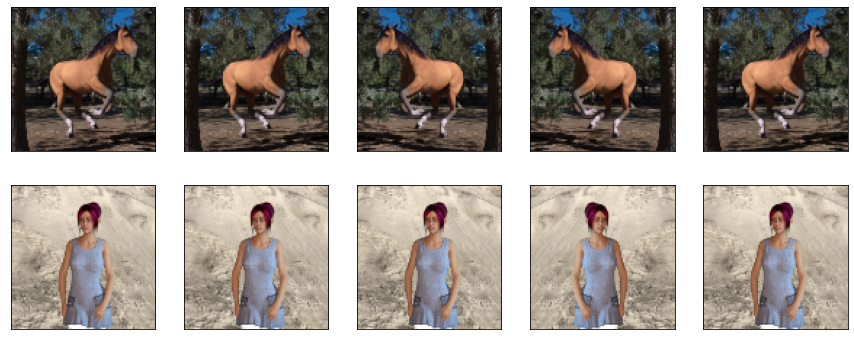

In [365]:
import tensorflow as tf
import matplotlib.pyplot as plt
ds=train_hh.shuffle(1000,reshuffle_each_iteration=False)
ds=ds.take(2).repeat(5)
ds=ds.map(lambda x: preprocess(x,size=(100,100)))
fig=plt.figure(figsize=(15,6))
for j,ex in enumerate(ds):
    ax=fig.add_subplot(2,5,j//2+(j%2)*5+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(ex[0])

plt.show()

In [366]:
import numpy as np
BATCH_SIZE=100
BUFFER_SIZE=100
IMAGE_SIZE=(150,150)
steps_per_epoch=np.ceil(1000/BATCH_SIZE)
ds_train=train_hh.map(lambda x: preprocess(x,size=IMAGE_SIZE))
ds_train=ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train=ds_train.batch(BATCH_SIZE)
ds_valid=test_hh.map(lambda x: preprocess(x,size=IMAGE_SIZE
                                          # ,mode='eval'
                                          ))
ds_valid=ds_valid.batch(BATCH_SIZE)


In [367]:
ds_train


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [374]:
"""большое количество параметров приводит к большим потерям и малой точности"""
from tensorflow.keras.layers import Dense,Dropout,Conv2D, MaxPool2D,Flatten

model=tf.keras.Sequential()
model.add(Conv2D(
    filters=32,kernel_size=(3,3),
    padding='same',
    name='conv_1',activation='relu',
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_1',
))

model.add(Dropout(
    0.5
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_2',activation='relu',
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_2'
))

model.add(Dropout(
    0.5
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_3',activation='relu',
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_3'
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_4',activation='relu',
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_4'
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_5',activation='relu',
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_5'
))

model.add(Dropout(
    0.5
))

# model.add(Conv2D(
#     filters=64,kernel_size=(3,3),
#     padding='same',
#     name='conv_6',activation='relu',
# ))
# model.add(MaxPool2D(
#     pool_size=(2,2),name='pool_6'
# ))
# model.compute_output_shape(input_shape=(None, 300, 300, 3))

In [375]:
from tensorflow.keras.layers import GlobalAvgPool2D,Flatten

# model.add(GlobalAvgPool2D())#вычисляет среднее каждого канала
model.add(Flatten())
model.compute_output_shape(input_shape=(None, 150, 150, 3))

TensorShape([None, 1024])

In [376]:
model.add(Dense(
    1024,name='fc_1',activation="relu",activity_regularizer='l2'
))
# model.add(Dropout(
#     0.2
# ))
# model.add(Dense(
#     16,activation="relu",activity_regularizer='l2'
# ))
model.add(Dense(
    1,activation='sigmoid'
))
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 dropout_102 (Dropout)       (None, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 75, 75, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 dropout_103 (Dropout)       (None, 37, 37, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 37, 37, 64)      

In [377]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.losses.BinaryFocalCrossentropy(from_logits=True),
              metrics=['binary_accuracy']
)
history=model.fit(
    ds_train,epochs=50,
    validation_data=ds_valid,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/50
10/10 [==============================] - 18s 2s/step - loss: 0.4019 - binary_accuracy: 0.4960 - val_loss: 0.1797 - val_binary_accuracy: 0.5000
Epoch

C:\Users\karim\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


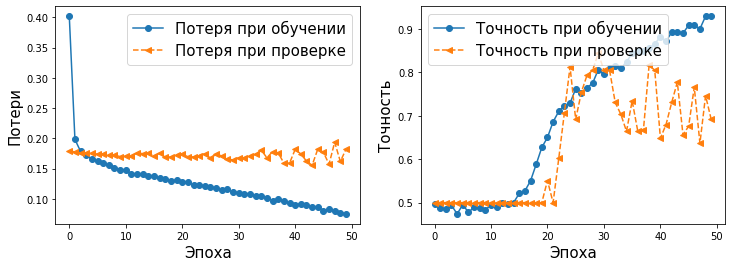

In [380]:

import matplotlib.pyplot as plt
import numpy as np
hist=history.history
x_arr=np.arange(len(hist['loss']))
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'-o',label='Потеря при обучении')
ax.plot(x_arr,hist['val_loss'],'--<',label='Потеря при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Потери",size=15)


ax=fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['binary_accuracy'],'-o',label='Точность при обучении')
ax.plot(x_arr,hist['val_binary_accuracy'],'--<',label='Точность при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Точность",size=15)
plt.show()